In [1]:
# notebooks/01_experiments.ipynb
#!pip install --upgrade pip numpy matplotlib scikit-image imageio pillow pandas --quiet

In [2]:
import sys, os

nb_dir      = os.getcwd()
project_root = (os.path.abspath(os.path.join(nb_dir, os.pardir))
                if nb_dir.endswith("notebooks") else nb_dir)
sys.path.insert(0, project_root)

%matplotlib inline

RAW_DIR   = os.path.join(project_root, "data", "raw")
DS_DIR    = os.path.join(project_root, "data", "downsampled")
RES_ROOT  = os.path.join(project_root, "data", "results")

os.makedirs(DS_DIR, exist_ok=True)
for method in ("bilinear", "bicubic"):
    os.makedirs(os.path.join(RES_ROOT, method), exist_ok=True)

# verificación 
print("Raw images:", os.listdir(RAW_DIR))
print("Downsampled dir:", DS_DIR)
print("Result dirs:", {m: os.path.join(RES_ROOT, m) for m in ("bilinear","bicubic")})

Raw images: ['retina.png', 'astronaut.png', 'hubble.png']
Downsampled dir: /Users/sebastianpedraza/Projects/hr_image_reconstruction/data/downsampled
Result dirs: {'bilinear': '/Users/sebastianpedraza/Projects/hr_image_reconstruction/data/results/bilinear', 'bicubic': '/Users/sebastianpedraza/Projects/hr_image_reconstruction/data/results/bicubic'}


In [3]:
import os
from skimage.transform import resize
from src.io.image_io            import load_image, save_image
from src.interpolation.bilinear import bilinear_interpolate
from src.interpolation.bicubic  import bicubic_interpolate
from src.metrics.psnr           import psnr
from src.metrics.ssim           import ssim
import numpy as np
import matplotlib.pyplot as plt

In [4]:
ds_factor = 0.5


In [5]:
file_list = sorted(f for f in os.listdir(RAW_DIR)
                   if f.lower().endswith((".png",".jpg",".jpeg")))

for fname in file_list:
    # --- Carga y downsample ---
    hr_path = os.path.join(RAW_DIR, fname)
    img_hr  = load_image(hr_path)
    h, w    = img_hr.shape
    img_lr  = resize(img_hr, (int(h*ds_factor), int(w*ds_factor)),
                     anti_aliasing=True)
    img_lr  = (img_lr * 255).astype(np.uint8)
    save_image(img_lr, os.path.join(DS_DIR, fname))

    # --- Reconstrucción ---
    alpha     = h / img_lr.shape[0]
    rec_bilin = bilinear_interpolate(img_lr, alpha)
    rec_bicub = bicubic_interpolate(img_lr, alpha)

    # --- Guardar resultados ---
    base, ext = os.path.splitext(fname)
    save_image(rec_bilin,
               os.path.join(RES_ROOT, "bilinear", f"{base}_bilinear{ext}"))
    save_image(rec_bicub,
               os.path.join(RES_ROOT, "bicubic",  f"{base}_bicubic{ext}"))

    # --- Cálculo y salida de métricas ---
    pb = psnr(img_hr, rec_bilin); pc = psnr(img_hr, rec_bicub)
    sb = ssim(img_hr, rec_bilin); sc = ssim(img_hr, rec_bicub)
    print(f"{fname}: PSNR B={pb:.2f} dB, C={pc:.2f} dB | SSIM B={sb:.3f}, C={sc:.3f}")

astronaut.png: PSNR B=27.18 dB, C=27.51 dB | SSIM B=0.907, C=0.914


hubble.png: PSNR B=29.52 dB, C=29.85 dB | SSIM B=0.787, C=0.794


retina.png: PSNR B=42.11 dB, C=42.44 dB | SSIM B=0.981, C=0.982


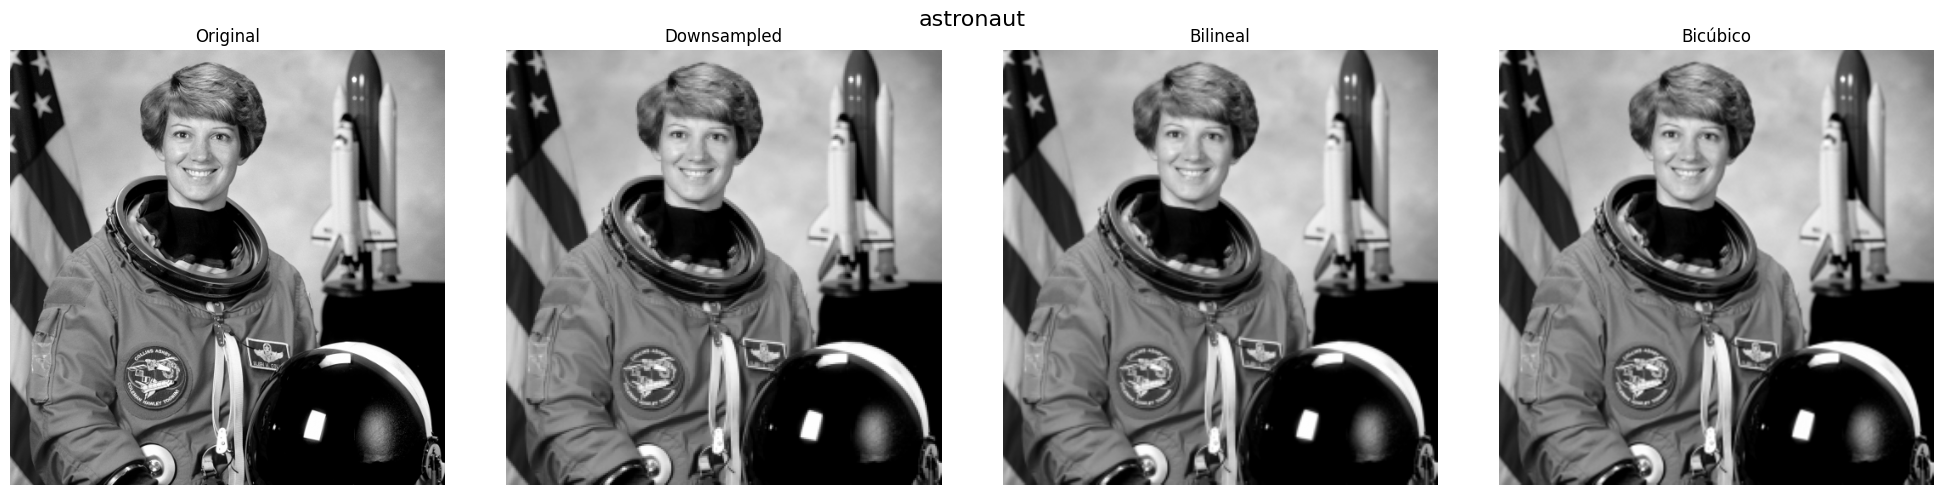

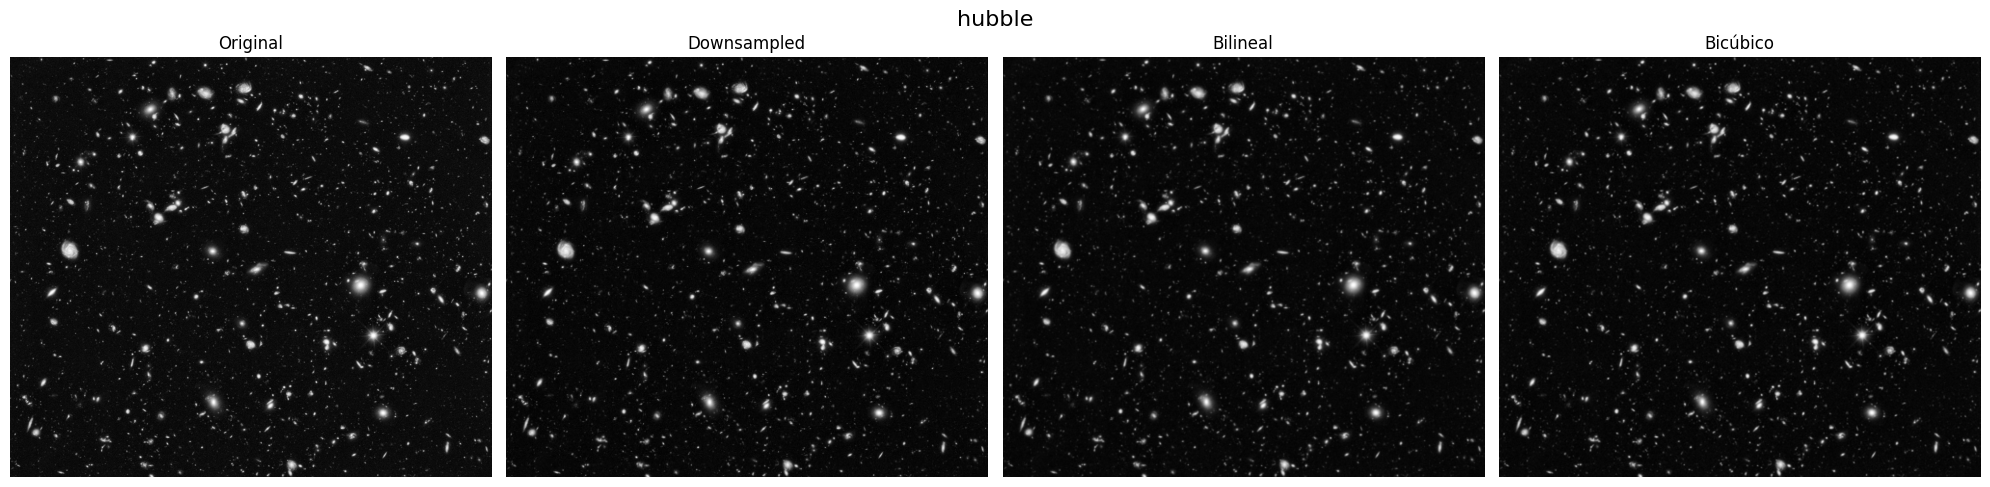

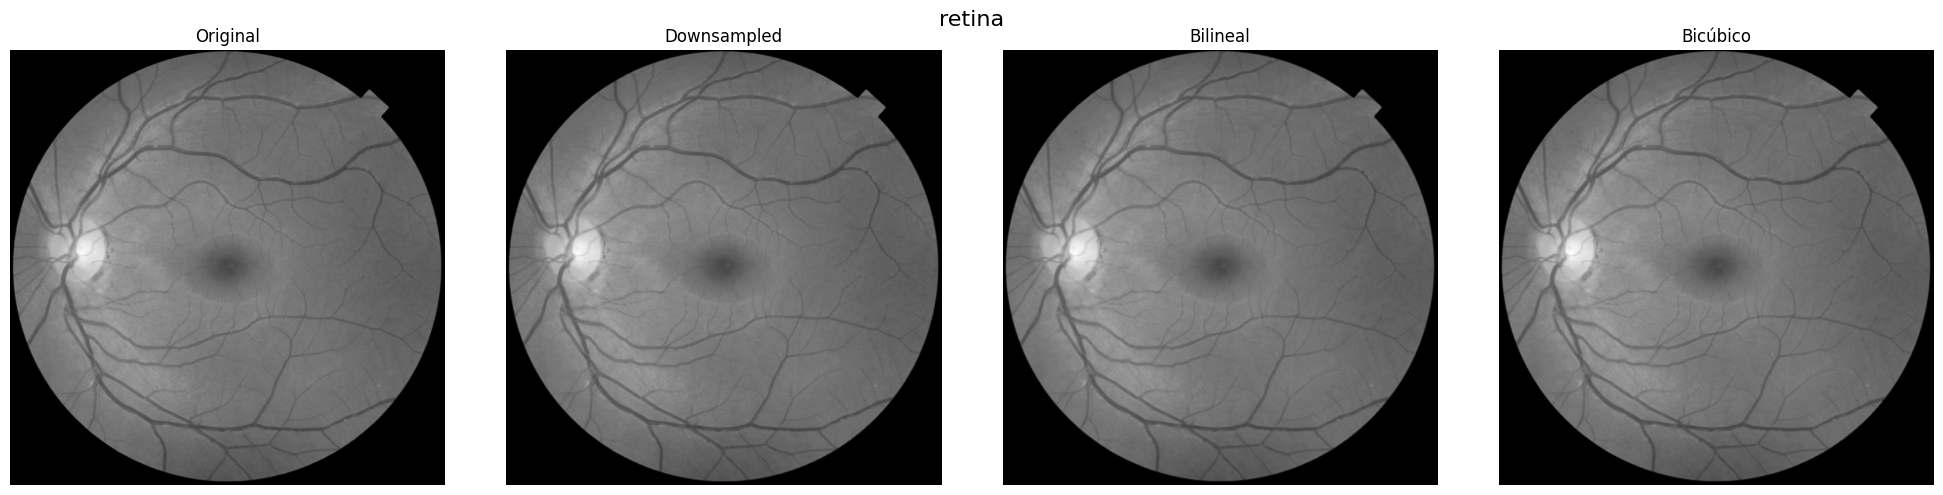

In [6]:
for fname in file_list:
    base, ext = os.path.splitext(fname)
    # Cargar original, downsampled y reconstrucciones
    img_hr    = load_image(os.path.join(RAW_DIR, fname))
    img_lr    = load_image(os.path.join(DS_DIR,  fname))
    rec_bilin = load_image(os.path.join(RES_ROOT, "bilinear", f"{base}_bilinear{ext}"))
    rec_bicub = load_image(os.path.join(RES_ROOT, "bicubic",  f"{base}_bicubic{ext}"))
    
    # Mostrar en 1x4
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    for ax, im, title in zip(axes,
                             [img_hr, img_lr, rec_bilin, rec_bicub],
                             ["Original", "Downsampled", "Bilineal", "Bicúbico"]):
        ax.imshow(im, cmap="gray")
        ax.set_title(title)
        ax.axis("off")
    plt.suptitle(base, fontsize=16)
    plt.tight_layout()
    plt.show()